<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/Lung_cancer_K_Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries

In [1]:
!pip install imblearn boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.9 MB/s eta 0:00:00


#Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data & preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# Estimators for RFE/Boruta
from sklearn.ensemble import RandomForestClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import make_scorer, accuracy_score

#Load data & Inspect

In [5]:
# Update path to the cancer patient data file
file_path = "/content/drive/MyDrive/DataSets/cancer patient data sets.csv"

df = pd.read_csv(file_path)
print("✅ Dataset loaded:", file_path)

print("\n--- Shape ---")
print(df.shape)

print("\n--- Columns ---")
print(df.columns.tolist())

print("\n--- First 5 rows ---")
print(df.head())

print("\n--- Info ---")
df.info()
df.shape

✅ Dataset loaded: /content/drive/MyDrive/DataSets/cancer patient data sets.csv

--- Shape ---
(1000, 26)

--- Columns ---
['index', 'Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath', 'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold', 'Dry Cough', 'Snoring', 'Level']

--- First 5 rows ---
   index Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      0         P1   33       1              2            4             5   
1      1        P10   17       1              3            1             5   
2      2       P100   35       1              4            5             6   
3      3      P1000   37       1              7            7             7   
4      4       P101   46       1              6          

(1000, 26)

# Clean & encode

In [6]:
# Define the new target column
target = 'Level'

# Normalize all column names (e.g., "Air Pollution" -> "air pollution")
df.columns = df.columns.str.strip().str.lower()
target = target.strip().lower()

# Drop identifier columns that are not useful for prediction
df = df.drop(columns=['index', 'patient id'], errors='ignore')

# Encode the target column ('Low', 'Medium', 'High') into numbers (0, 1, 2)
if target in df.columns:
    df[target] = LabelEncoder().fit_transform(df[target].astype(str))
    print(f"✅ Target column '{target}' encoded.")
else:
    print(f"❌ ERROR: Target column '{target}' not found!")

print("\n✅ Cleaned and encoded dataset:")
print(df.head())
df.info()

✅ Target column 'level' encoded.

✅ Cleaned and encoded dataset:
   age  gender  air pollution  alcohol use  dust allergy  \
0   33       1              2            4             5   
1   17       1              3            1             5   
2   35       1              4            5             6   
3   37       1              7            7             7   
4   46       1              6            8             7   

   occupational hazards  genetic risk  chronic lung disease  balanced diet  \
0                     4             3                     2              2   
1                     3             4                     2              2   
2                     5             5                     4              6   
3                     7             6                     7              7   
4                     7             7                     6              7   

   obesity  ...  fatigue  weight loss  shortness of breath  wheezing  \
0        4  ...        3         

#Quick EDA: class balance

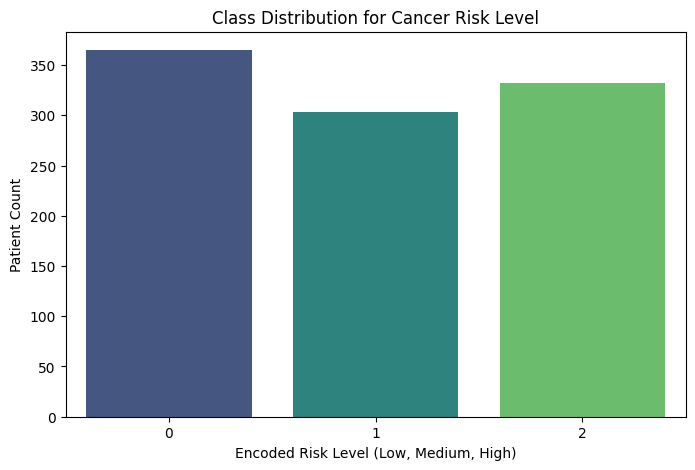

Class proportions:
level
0    0.365
2    0.332
1    0.303
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=df, palette='viridis')
plt.title(f'Class Distribution for Cancer Risk Level')
plt.xlabel('Encoded Risk Level (Low, Medium, High)')
plt.ylabel('Patient Count')
plt.show()

# Print the proportions of each class
print("Class proportions:")
print(df[target].value_counts(normalize=True).rename('proportion'))

#Quick EDA: correlations

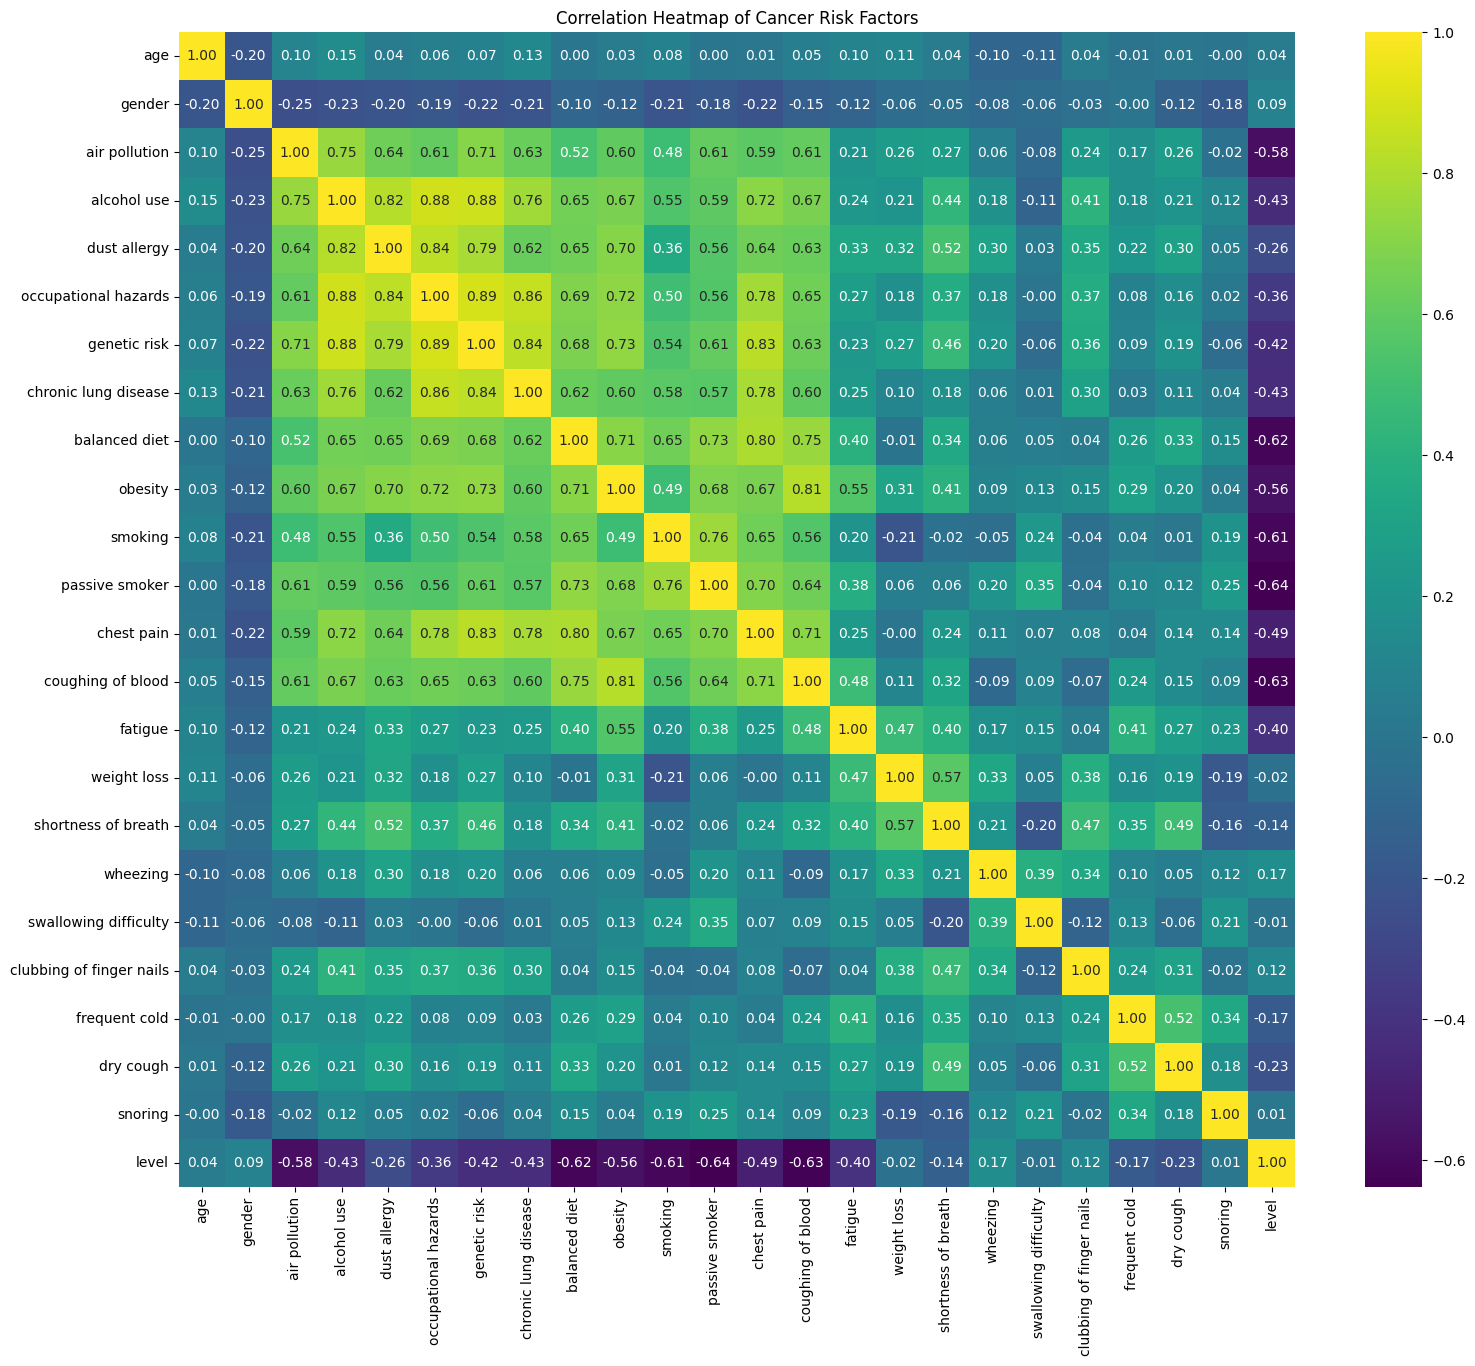

In [8]:
plt.figure(figsize=(18, 15))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Cancer Risk Factors')
plt.show()

# t-SNE visualization

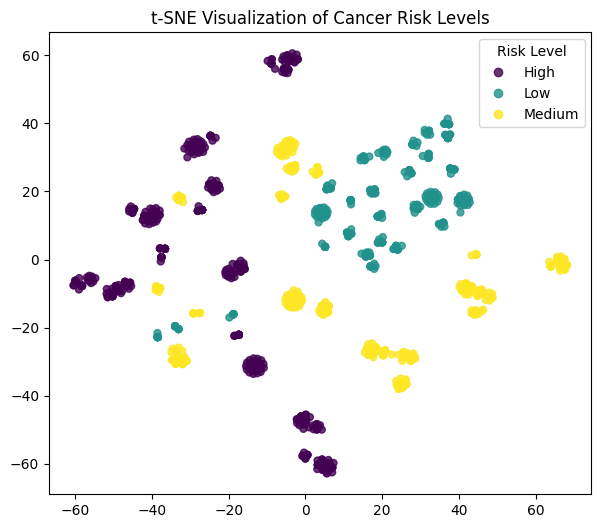

In [9]:
from sklearn.manifold import TSNE

X_vis = df.drop(columns=[target])
y_vis = df[target]

X_vis_scaled = StandardScaler().fit_transform(X_vis)

tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
X2 = tsne.fit_transform(X_vis_scaled)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y_vis, s=25, alpha=0.8, cmap='viridis')
plt.title('t-SNE Visualization of Cancer Risk Levels')
plt.legend(handles=scatter.legend_elements()[0], labels=['High', 'Low', 'Medium'], title="Risk Level")
plt.show()

#Define X / y

In [10]:
X = df.drop(columns=[target])
y = df[target].astype(int)

print("X (features) shape:", X.shape)
print("y (target) values:", np.unique(y))

X (features) shape: (1000, 23)
y (target) values: [0 1 2]


#Cross-validation plan

In [11]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score)}

# Scalers & classifiers

In [12]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
}

#Feature engineering blocks

In [13]:
def pca_block():
    return ('pca', PCA(n_components=0.95, random_state=42))

def lda_block():
    return ('lda', LDA(solver='svd'))

def rfe_block():
    base = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    # Select the top 12 features, as our dataset has 23 features
    return ('rfe', RFE(estimator=base, n_features_to_select=12, step=1))

def boruta_block():
    base = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced')
    return ('boruta', BorutaPy(estimator=base, n_estimators='auto', verbose=0, random_state=42, max_iter=50))

#Define all feature methods

In [14]:
feature_methods = {
    "All Features": [],
    "PCA": [pca_block()],
    "LDA": [lda_block()],
    "RFE": [rfe_block()],
    "Boruta": [boruta_block()]
}

#Run experiment

In [15]:
results = []

for scaler_name, scaler in scalers.items():
    for method_name, method_steps in feature_methods.items():
        for clf_name, clf in classifiers.items():

            steps = [('scaler', scaler)]

            # SMOTE and LDA cannot be used together in a standard pipeline
            if method_name != 'LDA':
                steps.append(('smote', SMOTE(random_state=42)))

            steps.extend(method_steps)
            steps.append(('clf', clf))

            pipe = Pipeline(steps)

            try:
                cv_out = cross_validate(
                    pipe, X, y,
                    cv=cv,
                    scoring=scoring,
                    return_train_score=False,
                    n_jobs=-1
                )

                fold_scores = cv_out['test_accuracy']

                results.append({
                    'Scaler': scaler_name,
                    'Method': method_name,
                    'Classifier': clf_name,
                    'Mean_Accuracy': float(np.mean(fold_scores)),
                    'Std_Accuracy': float(np.std(fold_scores, ddof=1))
                })
                print(f"Finished: {scaler_name} | {method_name} | {clf_name}")

            except Exception as e:
                print(f"FAILED: {scaler_name} | {method_name} | {clf_name} with error: {e}")

results_df = pd.DataFrame(results).sort_values('Mean_Accuracy', ascending=False).reset_index(drop=True)

print("\n✅ Done evaluating all combinations.")
results_df[['Scaler','Method','Classifier','Mean_Accuracy','Std_Accuracy']].head(10)

Finished: StandardScaler | All Features | Logistic Regression
Finished: StandardScaler | All Features | KNN
Finished: StandardScaler | All Features | SVM (RBF)
Finished: StandardScaler | All Features | Random Forest
Finished: StandardScaler | PCA | Logistic Regression
Finished: StandardScaler | PCA | KNN
Finished: StandardScaler | PCA | SVM (RBF)
Finished: StandardScaler | PCA | Random Forest
Finished: StandardScaler | LDA | Logistic Regression
Finished: StandardScaler | LDA | KNN
Finished: StandardScaler | LDA | SVM (RBF)
Finished: StandardScaler | LDA | Random Forest
Finished: StandardScaler | RFE | Logistic Regression
Finished: StandardScaler | RFE | KNN
Finished: StandardScaler | RFE | SVM (RBF)
Finished: StandardScaler | RFE | Random Forest
Finished: StandardScaler | Boruta | Logistic Regression
Finished: StandardScaler | Boruta | KNN
Finished: StandardScaler | Boruta | SVM (RBF)
Finished: StandardScaler | Boruta | Random Forest
Finished: MinMaxScaler | All Features | Logistic Reg

,Scaler,Method,Classifier,Mean_Accuracy,Std_Accuracy
0,StandardScaler,All Features,Logistic Regression,1.0,0.0
1,StandardScaler,All Features,KNN,1.0,0.0
2,StandardScaler,All Features,SVM (RBF),1.0,0.0
3,StandardScaler,All Features,Random Forest,1.0,0.0
4,StandardScaler,PCA,Logistic Regression,1.0,0.0
5,StandardScaler,PCA,KNN,1.0,0.0
6,StandardScaler,PCA,SVM (RBF),1.0,0.0
7,StandardScaler,PCA,Random Forest,1.0,0.0
8,StandardScaler,RFE,Random Forest,1.0,0.0
9,StandardScaler,RFE,SVM (RBF),1.0,0.0


#Pretty results table

In [16]:
disp = results_df.copy()
disp['Accuracy (mean ± std)'] = (disp['Mean_Accuracy']*100).round(2).astype(str) + \
                                 '% ± ' + (disp['Std_Accuracy']*100).round(2).astype(str) + '%'

cols = ['Scaler', 'Method', 'Classifier', 'Accuracy (mean ± std)', 'Mean_Accuracy']
disp_table = disp[cols].sort_values(by='Mean_Accuracy', ascending=False).drop(columns=['Mean_Accuracy'])

print("--- 🏆 Final Accuracy Results (mean ± std) ---")
print(disp_table.to_string(index=False))

--- 🏆 Final Accuracy Results (mean ± std) ---
        Scaler       Method          Classifier Accuracy (mean ± std)
StandardScaler All Features Logistic Regression         100.0% ± 0.0%
StandardScaler All Features                 KNN         100.0% ± 0.0%
StandardScaler All Features           SVM (RBF)         100.0% ± 0.0%
StandardScaler All Features       Random Forest         100.0% ± 0.0%
StandardScaler          PCA Logistic Regression         100.0% ± 0.0%
StandardScaler          PCA                 KNN         100.0% ± 0.0%
StandardScaler          PCA           SVM (RBF)         100.0% ± 0.0%
StandardScaler          PCA       Random Forest         100.0% ± 0.0%
StandardScaler          RFE       Random Forest         100.0% ± 0.0%
StandardScaler          RFE           SVM (RBF)         100.0% ± 0.0%
StandardScaler          RFE                 KNN         100.0% ± 0.0%
StandardScaler          RFE Logistic Regression         100.0% ± 0.0%
  MinMaxScaler All Features                 

#Plot top N combos

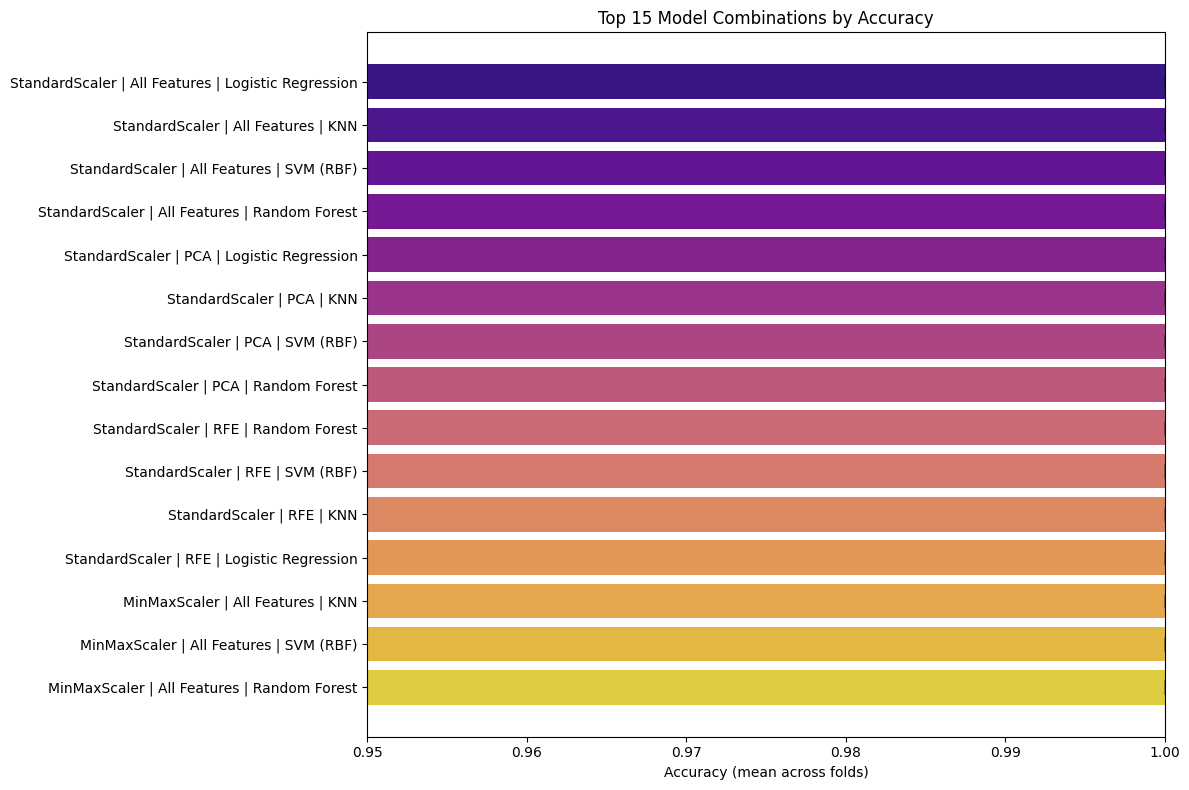

In [24]:
top_n = 15
plot_df = results_df.head(top_n).copy()
plot_df['label'] = plot_df['Scaler'] + ' | ' + plot_df['Method'] + ' | ' + plot_df['Classifier']

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y=plot_df['label'].tolist(),
    x=plot_df['Mean_Accuracy'].tolist(),
    palette='plasma'
)

# Manually add error bars
x = plot_df['Mean_Accuracy'].tolist()
y = range(len(plot_df))  # Create a numerical y-axis for errorbar
xerr = plot_df['Std_Accuracy'].tolist()

ax.errorbar(
    x, y,
    xerr=xerr,
    fmt='none', capsize=5, color='black' # Plot error bars without line, add caps, set color to black
)

plt.xlim(left=0.95, right=1.0) # Adjust x-axis to zoom in on top performers
plt.xlabel('Accuracy (mean across folds)')
plt.ylabel('')
plt.title(f'Top {top_n} Model Combinations by Accuracy')
plt.tight_layout()
plt.show()